# 6주차 스터디 

    1. 시계열 데이터 다루기 
    
    2. 주성분분석 (PCA) / 로지스틱회귀(LogisticRegression)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## 1. 시계열 데이터 다루기 

누락값처리 / 샘플링

### 1-1) 누락된 시계열 데이터 생성하고, 채워보기

* Forward Fill
* Moving average
* Interpolation

In [6]:
#파일을 불러올 떄, 처음부터 parse_dates=리스트 형태로 주어줘서 datetime으로 가져올 수 있다(위치숫자로도 줄 수 있음)

un_rate = pd.read_excel("실업률.xlsx", parse_dates=["Year"], index_col=0)

un_rate.index = un_rate.index.to_period()
un_rate

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [23]:
# 임으로 데이터를 누락한 데이터셋과 가장 높은 실업률을 기록한 달을 누락한 데이터셋을 분리해보자
np.random.seed(10)
random = un_rate.copy()

def change_random(x):
    x[np.random.randint(0,len(x))] = np.nan
    return x

random.apply(change_random, axis=1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,NaN,6.8,6.4
1978,6.4,6.3,6.3,6.1,NaN,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,NaN,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,NaN,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [24]:
# 2. 가장 실업률이 높은 월을 누락
## 참조) df.apply(axis=1) 이면 Column wise하게 함수를 날린다

max = un_rate.copy()

def change_max(x):
    x[np.argmax(x)] = np.nan
    return x

max.apply(change_max, axis=1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,NaN,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,NaN,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,NaN,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,NaN,7.7,7.5,7.5,7.5,7.2


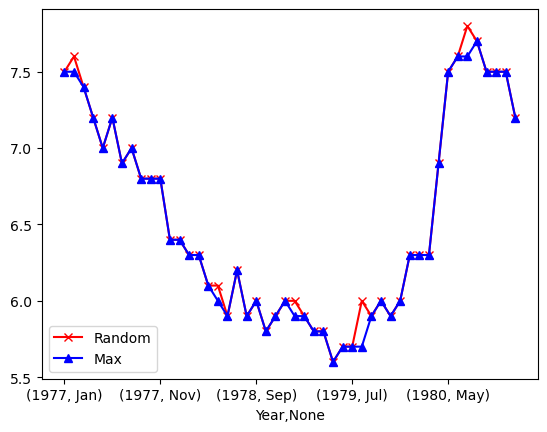

In [41]:
# 포워드필 -> 이전의 관측값으로 단순히 NaN 값을 채운다

random_ffill = random.stack(dropna=False).ffill()
max_ffill = max.stack(dropna=False).ffill()

random_ffill.plot(c="r", marker="x", label="Random")
max_ffill.plot(c="b", marker="^", label="Max")
plt.legend();

In [43]:
# 이동평균 -> 노이즈가 많은 데이터인 경우 포워드필 보다는 이동평균을 사용해야 한다(평균은 노이즈의 일부를 제거할 수 있다)

random_stack = random.stack(dropna=False)
random_stack.rolling(3, min_periods=1).mean()

Year     
1977  Jan    7.500000
      Feb    7.550000
      Mar    7.500000
      Apr    7.400000
      May    7.200000
      Jun    7.133333
      Jul    7.033333
      Aug    7.033333
      Sep    6.900000
      Oct    6.900000
      Nov    6.800000
      Dec    6.600000
1978  Jan    6.533333
      Feb    6.366667
      Mar    6.333333
      Apr    6.233333
      May    6.200000
      Jun    6.000000
      Jul    6.050000
      Aug    6.000000
      Sep    6.033333
      Oct    5.900000
      Nov    5.900000
      Dec    5.900000
1979  Jan    5.950000
      Feb    5.950000
      Mar    5.850000
      Apr    5.833333
      May    5.733333
      Jun    5.700000
      Jul    5.666667
      Aug    5.800000
      Sep    5.866667
      Oct    5.966667
      Nov    5.933333
      Dec    5.966667
1980  Jan    6.066667
      Feb    6.150000
      Mar    6.300000
      Apr    6.600000
      May    6.900000
      Jun    7.333333
      Jul    7.633333
      Aug    7.700000
      Sep    7.666667


In [45]:
# random_sample 데이터프레임의 NaN 값을 rolling 값으로 교체. 
# rolling().mean()은 NaN이 있는 경우 NaN을 리턴하기 때문에, min_periods=1로 설정

random_stack.fillna(random_stack.rolling(3, min_periods=1).mean()).unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.50,7.60,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.9,6.8,6.4
1978,6.40,6.30,6.3,6.1,6.2,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.95,5.90,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.30,6.15,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [47]:
# 이동평균 (지수평균)
random_stack.rolling(3, min_periods=1, win_type="exponential").mean().unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.500000,7.526894,7.536418,7.400000,7.200000,7.084777,7.094029,6.984777,6.936418,6.853788,6.800000,6.692423
1978,6.484777,6.378806,6.321194,6.257612,6.153788,6.000000,5.980682,6.072835,5.984777,5.936418,5.863582,5.900000
1979,5.973106,5.950000,5.873106,5.821194,5.757612,5.663582,5.678806,5.763582,5.915223,5.942388,5.957612,5.942388
1980,6.042388,6.219318,6.300000,6.461365,6.900000,7.394029,7.621194,7.736418,7.678806,7.542388,7.500000,7.436418


In [50]:
# 보간법
## 누락된 값을 대치할 때, 이미 알고 있는 지식에 기반하여 특정한 경향을 사용하게끔 제한할 수 있다. -> 시간에 따라 시스템이 동작하는 방식을 알고 있고, 그 지식을 활용할 때 특히 유용한 방식이다
random_stack.interpolate("linear").unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.50,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.40,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.95,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.30,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


### 1-2) 샘플링

* 다운샘플링: 데이터의 빈도를 줄인다

* 업샘플링 : 데이터의 빈도를 늘린다 (Not Free Lunch -> 더 많은 시간 레이블을 얻을 수는 있지만, 더 많은 정보가 추가되는 것은 아니다)


* 판다스의 resample을 사용할 수 있다

In [59]:
# 다운 샘플링 예시) 시계열의 1월 부분에만 집중하는 경우
idx = un_rate.stack().index.get_level_values(1) == "Jan"

un_rate.stack()[idx]

Year     
1977  Jan    7.5
1978  Jan    6.4
1979  Jan    5.9
1980  Jan    6.3
dtype: float64

### 1-3) 데이터 평활

In [62]:
# 데이터 불러오기
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv",
                  names=['Date', 'Passengers'], index_col=0, parse_dates=True)
air.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


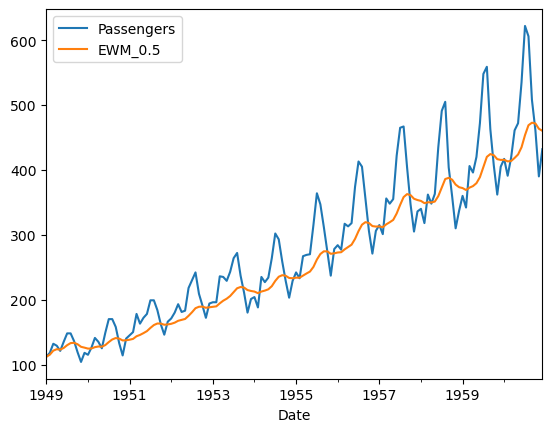

In [67]:
# 지수평활 
air["EWM_0.5"] = air.Passengers.ewm(alpha=0.1).mean()

air.plot();

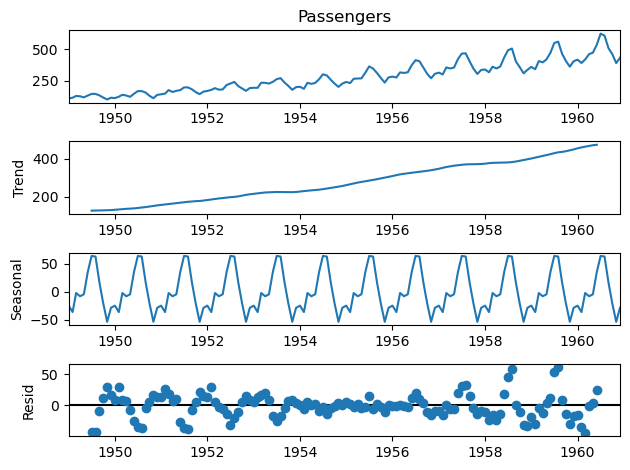

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(air.Passengers, model="additive")
result.plot();

In [74]:
result.seasonal[10:20] 

Date
1949-11-01   -53.593434
1949-12-01   -28.619949
1950-01-01   -24.748737
1950-02-01   -36.188131
1950-03-01    -2.241162
1950-04-01    -8.036616
1950-05-01    -4.506313
1950-06-01    35.402778
1950-07-01    63.830808
1950-08-01    62.823232
Name: seasonal, dtype: float64

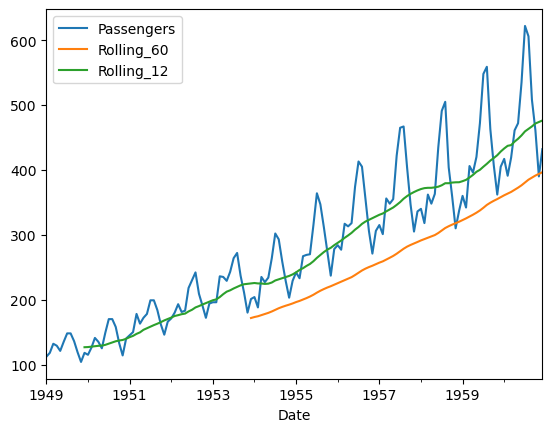

In [79]:
air["Rolling_60"] = air.Passengers.rolling(window=60).mean()
air["Rolling_12"] = air.Passengers.rolling(window=12).mean()

air[["Passengers","Rolling_60","Rolling_12"]].plot();

## 2. 주성분분석(PCA)

차원축소의 기법 중 하나

데이터의 분산을 최대한 보존하는 방향으로 데이터의 차원을 축소함

In [81]:
# 3차원 데이터 생성
m = 1000
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

array([[-1.02203862, -0.13444853, -0.16305185],
       [ 1.13856056,  0.32385581,  0.22166903],
       [-1.16591636, -0.29789564, -0.2686339 ],
       ...,
       [-1.04344005, -0.09954664,  0.00381533],
       [ 0.27163218,  0.69912361,  0.30822935],
       [-0.94144769,  0.03914771, -0.03018377]])

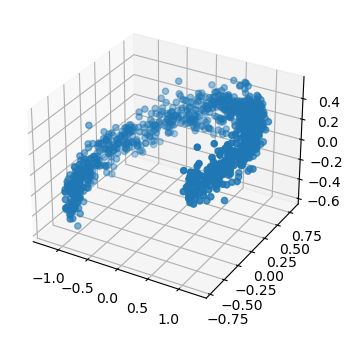

In [86]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2]);

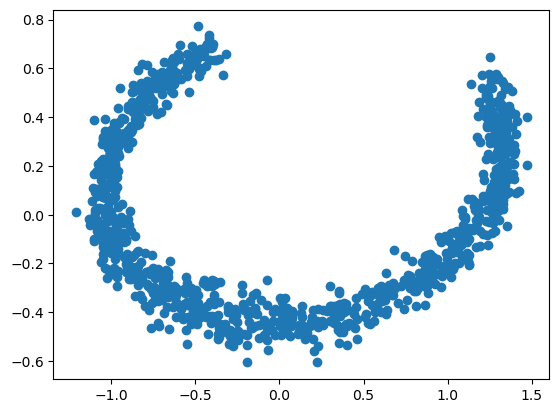

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1]);

In [89]:
pca.explained_variance_ratio_

array([0.8565625 , 0.13384615])

PCA를 사용한 모델 학습

In [90]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [91]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_reduced_test = pca.transform(X_test)

In [94]:
# 그냥 학습하는 경우 (최적화의 기본개념 + 로지스틱 회귀란?)
import time
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print(t1-t0)

87.71955299377441


c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
log_clf.score(X_test,y_test)

0.9208571428571428

In [95]:
# PCA로 차원을 줄인 데이터로 학습할 경우

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs")
t0 = time.time()
log_clf.fit(X_reduced, y_train)
t1 = time.time()

print(t1-t0)

4.390010118484497


c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
# PCA로 차원을 축소시킨 모형의 정확도 확인
log_clf.score(X_reduced_test, y_test)

0.9145142857142857